<a href="https://colab.research.google.com/github/Deniz-shelby/Studienarbeit/blob/main/Prognose_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive, files

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7onueXnb6YOUKzXPhb0gLaSVshTo8xDYJvCCwlapuVoex8QY46wB8
Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import numpy as np
import time
import random
import pytz
from pytz import timezone
from tzlocal import get_localzone
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#load Json

In [ ]:
with open("/content/drive/My Drive/Studienarbeit/acndata_Caltech_04-06:2019.json", "r", encoding='utf-8') as json_file:
    data_load = json.load(json_file)

#Data Frame erzeugen  



In [ ]:
userID = [ sub['userID'] for sub in data_load ]

connectionTime_preparse = [sub ['connectionTime'] for sub in data_load ]

disconnectTime_preparse = [sub ['disconnectTime'] for sub in data_load ]

doneChargingTime_preparse = [ sub['doneChargingTime'] for sub in data_load ]

kWhDelivered = [sub ['kWhDelivered'] for sub in data_load ]

df_na = pd.DataFrame(list(zip(userID,connectionTime_preparse,disconnectTime_preparse,doneChargingTime_preparse,kWhDelivered)),
                      columns = ['userID','connectionTime_preparse','disconnectTime_preparse','doneChargingTime_preparse','kWhDelivered'])

drop none

In [ ]:
df_pre_parse = df_na.mask(df_na.astype(object).eq('None')).dropna() 
print(df_pre_parse)

         userID  ... kWhDelivered
0     000001083  ...        6.219
1     000000489  ...        0.562
2     000000243  ...        3.870
3     000001093  ...        0.789
4     000000365  ...        4.501
...         ...  ...          ...
2006  000001152  ...       11.865
2007  000000675  ...        8.082
2009  000001133  ...        6.062
2011  000000365  ...        2.502
2014  000000891  ...        1.790

[1735 rows x 5 columns]


# String parse to time & timezone function

---



In [ ]:
# functionen für strin-parse & timezone

def string_parse_datetime_list(str_list, timeformat):
  return [dt.strptime(x, timeformat) for x in str_list]

def change_timezone_as_list(datetime_list,new_timezone):
  new_datetime_list = []
  for i in range(len(datetime_list)):
    new_datetime_list.append(datetime_list[i].astimezone(timezone(new_timezone)))
  return new_datetime_list

# Str parse to dt

In [ ]:
timeformat= '%a, %d %b %Y %H:%M:%S %Z'

connectionTime_utc = string_parse_datetime_list(df_pre_parse['connectionTime_preparse'], timeformat)

disconnectTime_utc = string_parse_datetime_list(df_pre_parse['disconnectTime_preparse'], timeformat)

doneChargingTime_utc = string_parse_datetime_list(df_pre_parse['doneChargingTime_preparse'], timeformat)


#create list with date, time intervall and parse

In [ ]:
timeintervall = 15

def daterange(start_date, end_date):
    delta = timedelta(minutes=timeintervall)
    while start_date < end_date:
        yield start_date
        start_date += delta

zeitreihe_utc = []
start_date_zeitreihe = dt(2019, 4, 1, 7, 00, 00)
end_date_zeitreihe = dt(2019, 6, 1, 7, 00, 15)
for single_date in daterange(start_date_zeitreihe, end_date_zeitreihe):
    zeitreihe_utc.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))
zeitreihe_utc = [dt.strptime(x,'%Y-%m-%d %H:%M:%S') for x in zeitreihe_utc]
len(zeitreihe_utc)
print(zeitreihe_utc)

[datetime.datetime(2019, 4, 1, 7, 0), datetime.datetime(2019, 4, 1, 7, 15), datetime.datetime(2019, 4, 1, 7, 30), datetime.datetime(2019, 4, 1, 7, 45), datetime.datetime(2019, 4, 1, 8, 0), datetime.datetime(2019, 4, 1, 8, 15), datetime.datetime(2019, 4, 1, 8, 30), datetime.datetime(2019, 4, 1, 8, 45), datetime.datetime(2019, 4, 1, 9, 0), datetime.datetime(2019, 4, 1, 9, 15), datetime.datetime(2019, 4, 1, 9, 30), datetime.datetime(2019, 4, 1, 9, 45), datetime.datetime(2019, 4, 1, 10, 0), datetime.datetime(2019, 4, 1, 10, 15), datetime.datetime(2019, 4, 1, 10, 30), datetime.datetime(2019, 4, 1, 10, 45), datetime.datetime(2019, 4, 1, 11, 0), datetime.datetime(2019, 4, 1, 11, 15), datetime.datetime(2019, 4, 1, 11, 30), datetime.datetime(2019, 4, 1, 11, 45), datetime.datetime(2019, 4, 1, 12, 0), datetime.datetime(2019, 4, 1, 12, 15), datetime.datetime(2019, 4, 1, 12, 30), datetime.datetime(2019, 4, 1, 12, 45), datetime.datetime(2019, 4, 1, 13, 0), datetime.datetime(2019, 4, 1, 13, 15), date

# change Timezone

In [ ]:
new_timezone = 'America/Los_Angeles'

connectionTime_aware = change_timezone_as_list(connectionTime_utc,new_timezone)

disconnectTime_aware = change_timezone_as_list(disconnectTime_utc ,new_timezone)

doneChargingTime_aware = change_timezone_as_list(doneChargingTime_utc,new_timezone)

zeitreihe_aware = change_timezone_as_list(zeitreihe_utc,new_timezone)

print(zeitreihe_aware)

[datetime.datetime(2019, 4, 1, 0, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 0, 15, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 0, 30, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 0, 45, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 1, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 1, 15, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 1, 30, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 1, 45, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 2, 0, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>), datetime.datetime(2019, 4, 1, 2, 15, tzinfo=<DstTzInfo 'America/Lo



change matplotlib timezone

In [ ]:

rcParams['timezone'] = new_timezone

# build Dataframe

In [ ]:
df = pd.DataFrame(list(zip(df_pre_parse['userID'],connectionTime_aware,disconnectTime_aware,doneChargingTime_aware,df_pre_parse['kWhDelivered'])),
                      columns = ['userID','connectionTime','disconnectTime','doneChargingTime','kWhDelivered'])

In [ ]:
df


,userID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered
0,000001083,2019-03-31 12:40:43-07:00,2019-03-31 19:26:57-07:00,2019-03-31 19:26:52-07:00,6.219
1,000000489,2019-03-31 14:16:46-07:00,2019-03-31 14:23:08-07:00,2019-03-31 14:23:03-07:00,0.562
2,000000243,2019-03-31 16:07:33-07:00,2019-03-31 16:46:29-07:00,2019-03-31 16:46:21-07:00,3.870
3,000001093,2019-03-31 16:21:59-07:00,2019-03-31 18:41:26-07:00,2019-03-31 16:45:20-07:00,0.789
4,000000365,2019-03-31 16:35:22-07:00,2019-03-31 17:55:10-07:00,2019-03-31 17:55:02-07:00,4.501
...,...,...,...,...,...
1730,000001152,2019-05-31 21:32:23-07:00,2019-06-01 09:27:29-07:00,2019-06-01 00:55:35-07:00,11.865
1731,000000675,2019-06-01 07:55:43-07:00,2019-06-01 09:44:17-07:00,2019-06-01 09:20:10-07:00,8.082
1732,000001133,2019-06-01 09:59:26-07:00,2019-06-01 11:27:58-07:00,2019-06-01 11:03:24-07:00,6.062
1733,000000365,2019-06-01 10:45:34-07:00,2019-06-01 11:28:51-07:00,2019-06-01 11:28:42-07:00,2.502


#User Id and Max_kWh

In [ ]:
df_userID_kWhDelivered = df[["userID", "kWhDelivered"]]
print(df_userID_kWhDelivered)


#Create a dictionary, using the List items as keys. This will automatically remove any duplicates because dictionaries cannot have duplicate keys.
#Then, convert the dictionary back into a list:
user_id_list = list(dict.fromkeys(df_userID_kWhDelivered['userID'])) 



         userID  kWhDelivered
0     000001083         6.219
1     000000489         0.562
2     000000243         3.870
3     000001093         0.789
4     000000365         4.501
...         ...           ...
1730  000001152        11.865
1731  000000675         8.082
1732  000001133         6.062
1733  000000365         2.502
1734  000000891         1.790

[1735 rows x 2 columns]


In [ ]:
print(user_id_list)

['000001083', '000000489', '000000243', '000001093', '000000365', '000001082', '000000781', '000000560', '000000569', '000001470', '000000562', '000000712', '000000559', '000000579', '000000714', '000000743', '000001534', '000001526', '000000324', '000000676', '000000858', '000000620', '000001481', '000000558', '000000609', '000001087', '000001236', '000001243', '000000891', '000001135', '000000777', '000001164', '000000838', '000001202', '000001104', '000000069', '000000945', '000000515', '000001137', '000000567', '000001957', '000001095', '000000234', '000001001', '000000710', '000001912', '000001746', '000001089', '000001991', '000000850', '000000632', '000000832', '000000774', '000001161', '000002069', '000001099', '000000301', '000001524', '000000347', '000001154', '000000171', '000001953', '000000752', '000001039', '000000867', '000001108', '000001263', '000000818', '000001208', '000001274', '000001124', '000000248', '000001384', '000002192', '000001826', '000001142', '000000675'

function to get Max_kWh for userID

In [ ]:
def get_df_Max_kWh(id_list, df, df_userID, capacity_factor):

  Max_kWh_id_list = []
  for i in range(len(id_list)):
    ID_list = df_userID == id_list[i]
    df_ID_list = df[ID_list]
    Max_kWh_holder = capacity_factor * max(df_ID_list['kWhDelivered'].values)
    Max_kWh_id_list.append(Max_kWh_holder)

  df_Max_kWh = pd.DataFrame(list(zip(id_list,Max_kWh_id_list)),
                      columns = ['userID','battery_capacity[kWh]'])
  
  return df_Max_kWh


use function get Max_kWh for userID

In [ ]:
df_Max_kWh = get_df_Max_kWh(user_id_list,df_userID_kWhDelivered, df_userID_kWhDelivered['userID'],1.25)

In [ ]:
print(df_Max_kWh)

        userID  battery_capacity[kWh]
0    000001083                8.03750
1    000000489               67.22375
2    000000243                8.49000
3    000001093                7.52375
4    000000365                5.62625
..         ...                    ...
156  000001007               13.80125
157  000001272               19.21000
158  000002611                7.34750
159  000001752                6.00875
160  000002607               13.59500

[161 rows x 2 columns]


add new colum to df_userID_kWhDelivered

In [ ]:
df_userID_kWhDelivered['battery_capacity[kWh]'] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


function to add battery_capacity values to dataframe

In [ ]:
def add_value_from_df_to_df_with_same_column_values(df_add, df_to_add,add_same_column,to_add_same_column,add_column, to_add_column):
  for i in range(len(df_add)):
    for j in range(len(df_to_add)):
      if df_add.iloc[i, add_same_column] == df_to_add.iloc[j , to_add_same_column]:
        df_add.iloc[i, add_column] = df_to_add.iloc[j, to_add_column]
  return df_add

In [ ]:
df_userID_kWhDelivered = add_value_from_df_to_df_with_same_column_values(df_userID_kWhDelivered,df_Max_kWh, 0, 0, 2, 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
print(df_userID_kWhDelivered)

         userID  kWhDelivered battery_capacity[kWh]
0     000001083         6.219                8.0375
1     000000489         0.562               67.2238
2     000000243         3.870                  8.49
3     000001093         0.789               7.52375
4     000000365         4.501               5.62625
...         ...           ...                   ...
1730  000001152        11.865               19.4738
1731  000000675         8.082                15.235
1732  000001133         6.062               9.86875
1733  000000365         2.502               5.62625
1734  000000891         1.790               7.32875

[1735 rows x 3 columns]


get battery capacity in %

In [ ]:
def get_percent_of_two_columns(df, name_new_column ,new_column_to_add, column_to_divide, column_divide,percent_digits ):
  df[name_new_column] = ''
  for i in range(len(df)):
    df.iloc[i, new_column_to_add] = round(df.iloc[i, column_to_divide]/df.iloc[i,column_divide],percent_digits)*100
  return df

In [ ]:
df_userID_kWhDelivered = get_percent_of_two_columns(df_userID_kWhDelivered, 'battery_capacity[%]',3,1,2,4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
print(df_userID_kWhDelivered)

         userID  kWhDelivered battery_capacity[kWh] battery_capacity[%]
0     000001083         6.219                8.0375               77.37
1     000000489         0.562               67.2238                0.84
2     000000243         3.870                  8.49               45.58
3     000001093         0.789               7.52375               10.49
4     000000365         4.501               5.62625                  80
...         ...           ...                   ...                 ...
1730  000001152        11.865               19.4738               60.93
1731  000000675         8.082                15.235               53.05
1732  000001133         6.062               9.86875               61.43
1733  000000365         2.502               5.62625               44.47
1734  000000891         1.790               7.32875               24.42

[1735 rows x 4 columns]


# pandas to display Max columns of df

In [ ]:
pd.set_option('display.max_columns', 5000)

# Define SoC

difference between connection-disconnect & connection-donecharging 

In [ ]:
def add_new_colum_with_timedifference_of_two_columns_in_min(df, name_new_column, first_time_column, second_time_column, new_column):
  df[name_new_column] = ''
  for i in range(len(df)):
    diff_holder = df.iloc[i, second_time_column] - df.iloc[i,first_time_column]
    diff_holder = diff_holder.seconds//60
    df.iloc[i, new_column] = diff_holder
  return df 

In [ ]:
df_all = df

df_all = add_new_colum_with_timedifference_of_two_columns_in_min(df_all,'diff_con_discon[min]',1,2,5)
df_all = add_new_colum_with_timedifference_of_two_columns_in_min(df_all,'diff_con_done[min]',1,3,6)



if diff_con_done > diff_con_discon then SoC_end = 100%

In [ ]:
df_all['SoC_start[%]'] = ''
df_all['SoC_end[%]'] = ''

for i in range(len(df_all)):
  if df_all.iloc[i,5] >  df_all.iloc[i,6]:
    df_all.iloc[i,8] = 100
  
print(df_all)

         userID            connectionTime            disconnectTime  \
0     000001083 2019-03-31 12:40:43-07:00 2019-03-31 19:26:57-07:00   
1     000000489 2019-03-31 14:16:46-07:00 2019-03-31 14:23:08-07:00   
2     000000243 2019-03-31 16:07:33-07:00 2019-03-31 16:46:29-07:00   
3     000001093 2019-03-31 16:21:59-07:00 2019-03-31 18:41:26-07:00   
4     000000365 2019-03-31 16:35:22-07:00 2019-03-31 17:55:10-07:00   
...         ...                       ...                       ...   
1730  000001152 2019-05-31 21:32:23-07:00 2019-06-01 09:27:29-07:00   
1731  000000675 2019-06-01 07:55:43-07:00 2019-06-01 09:44:17-07:00   
1732  000001133 2019-06-01 09:59:26-07:00 2019-06-01 11:27:58-07:00   
1733  000000365 2019-06-01 10:45:34-07:00 2019-06-01 11:28:51-07:00   
1734  000000891 2019-06-01 11:59:32-07:00 2019-06-01 13:54:28-07:00   

              doneChargingTime  kWhDelivered diff_con_discon[min]  \
0    2019-03-31 19:26:52-07:00         6.219                  406   
1    2019

merge df_all and df_userID_kWhDelivered

In [ ]:
df_all_merged = pd.concat([df_all,df_userID_kWhDelivered],axis=1)


drop duplicated columns

In [ ]:
df_all_merged = df_all_merged.iloc[:,~df_all_merged.columns.duplicated()]
df_all_merged

,userID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,diff_con_discon[min],diff_con_done[min],SoC_start[%],SoC_end[%],battery_capacity[kWh],battery_capacity[%]
0,000001083,2019-03-31 12:40:43-07:00,2019-03-31 19:26:57-07:00,2019-03-31 19:26:52-07:00,6.219,406,406,,,8.0375,77.37
1,000000489,2019-03-31 14:16:46-07:00,2019-03-31 14:23:08-07:00,2019-03-31 14:23:03-07:00,0.562,6,6,,,67.2238,0.84
2,000000243,2019-03-31 16:07:33-07:00,2019-03-31 16:46:29-07:00,2019-03-31 16:46:21-07:00,3.870,38,38,,,8.49,45.58
3,000001093,2019-03-31 16:21:59-07:00,2019-03-31 18:41:26-07:00,2019-03-31 16:45:20-07:00,0.789,139,23,,100,7.52375,10.49
4,000000365,2019-03-31 16:35:22-07:00,2019-03-31 17:55:10-07:00,2019-03-31 17:55:02-07:00,4.501,79,79,,,5.62625,80
...,...,...,...,...,...,...,...,...,...,...,...
1730,000001152,2019-05-31 21:32:23-07:00,2019-06-01 09:27:29-07:00,2019-06-01 00:55:35-07:00,11.865,715,203,,100,19.4738,60.93
1731,000000675,2019-06-01 07:55:43-07:00,2019-06-01 09:44:17-07:00,2019-06-01 09:20:10-07:00,8.082,108,84,,100,15.235,53.05
1732,000001133,2019-06-01 09:59:26-07:00,2019-06-01 11:27:58-07:00,2019-06-01 11:03:24-07:00,6.062,88,63,,100,9.86875,61.43
1733,000000365,2019-06-01 10:45:34-07:00,2019-06-01 11:28:51-07:00,2019-06-01 11:28:42-07:00,2.502,43,43,,,5.62625,44.47


If SoC_end is 100 then subtract battery_capacity for SoC_start

In [ ]:
df_all_merged = pd.DataFrame(df_all_merged)
for i in range(len(df_all_merged)):
  if df_all_merged.iloc[i,8] == 100:
    SoC_start_holder = 100 - df_all_merged.iloc[i,10]
    df_all_merged.iloc[i,7] = SoC_start_holder


use random uniform before and after eleven for SoC start

In [ ]:
SoC_beforeeleven_list = np.random.uniform(60,80,1000)
SoC_aftereleven_list = np.random.uniform(40,60,1000)

time_eleven = dt.strptime('11:00:00','%H:%M:%S')
time_eleven = time_eleven.time()

In [ ]:
for i in range(len(df_all_merged)):
  if df_all_merged.iloc[i,8] != 100 and df_all_merged.iloc[0,1].time() < time_eleven:
    df_all_merged.iloc[i,7] = round(random.choice(SoC_beforeeleven_list),2)
    df_all_merged.iloc[i,8] = df_all_merged.iloc[i,7] + df_all_merged.iloc[i,10]
  elif df_all_merged.iloc[i,8] != 100:
    df_all_merged.iloc[i,7] = round(random.choice(SoC_aftereleven_list),2)
    df_all_merged.iloc[i,8] = df_all_merged.iloc[i,7] + df_all_merged.iloc[i,10]
  
  if df_all_merged.iloc[i,8] > 100:
    df_all_merged.iloc[i,7] = 100 - df_all_merged.iloc[i,10]
    df_all_merged.iloc[i,8] = 100

In [ ]:
df_all_merged

,userID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,diff_con_discon[min],diff_con_done[min],SoC_start[%],SoC_end[%],battery_capacity[kWh],battery_capacity[%]
0,000001083,2019-03-31 12:40:43-07:00,2019-03-31 19:26:57-07:00,2019-03-31 19:26:52-07:00,6.219,406,406,22.63,100,8.0375,77.37
1,000000489,2019-03-31 14:16:46-07:00,2019-03-31 14:23:08-07:00,2019-03-31 14:23:03-07:00,0.562,6,6,44.37,45.21,67.2238,0.84
2,000000243,2019-03-31 16:07:33-07:00,2019-03-31 16:46:29-07:00,2019-03-31 16:46:21-07:00,3.870,38,38,54.42,100,8.49,45.58
3,000001093,2019-03-31 16:21:59-07:00,2019-03-31 18:41:26-07:00,2019-03-31 16:45:20-07:00,0.789,139,23,89.51,100,7.52375,10.49
4,000000365,2019-03-31 16:35:22-07:00,2019-03-31 17:55:10-07:00,2019-03-31 17:55:02-07:00,4.501,79,79,20,100,5.62625,80
...,...,...,...,...,...,...,...,...,...,...,...
1730,000001152,2019-05-31 21:32:23-07:00,2019-06-01 09:27:29-07:00,2019-06-01 00:55:35-07:00,11.865,715,203,39.07,100,19.4738,60.93
1731,000000675,2019-06-01 07:55:43-07:00,2019-06-01 09:44:17-07:00,2019-06-01 09:20:10-07:00,8.082,108,84,46.95,100,15.235,53.05
1732,000001133,2019-06-01 09:59:26-07:00,2019-06-01 11:27:58-07:00,2019-06-01 11:03:24-07:00,6.062,88,63,38.57,100,9.86875,61.43
1733,000000365,2019-06-01 10:45:34-07:00,2019-06-01 11:28:51-07:00,2019-06-01 11:28:42-07:00,2.502,43,43,47.09,91.56,5.62625,44.47


#dataframe save as csv 




In [ ]:
#df_all_merged.to_csv(r'/content/drive/My Drive/Studienarbeit/df_all_merged.csv')

# Find SoC and kWh for the location with potential kWh

In [ ]:
connectionTime = df_all_merged['connectionTime']

disconnectTime = df_all_merged['disconnectTime']

function for current kWh for the location

In [ ]:
def current_kWh_for_location(df, timeline, start_time, end_time,SoC_start_column, battery_capacity_column, kWhDelivered_column ):
  car_parked = []
  parked_kWh_SoC = []

  j= -1
  for i in range(len(df)): #df
    j = j + 1
    car_parked = []
    parked_kWh_SoC = []
    parked_kWh_Max = []

    for i in range(len(timeline)): #timeline
      if start_time[j] <= timeline[i] and end_time[j] > timeline[i]: #start_time & end_time
        car_parked.append(1)
      else:
        car_parked.append(0)

    if sum(car_parked) > 0:
      SoC_start_holder = round(SoC_start_column[j]*battery_capacity_column[j]/100 ,2) #Soc_start_column * baterry_capacity_column/100
      kWh_holder = round(kWhDelivered_column[j]/sum(car_parked),2)# kWhDelivered_column & with sum(9car_parked) linear interpolation
      parked_kWh_SoC = [i* SoC_start_holder for i in car_parked] # multiplicate two lists
      parked_kWh_Max = [i* battery_capacity_column[j] for i in car_parked] # potential kWh capacity
  
      for i in range(len(parked_kWh_SoC)):
        if parked_kWh_SoC[i-1] != 0 and parked_kWh_SoC[i] != 0:
          parked_kWh_SoC[i] = parked_kWh_SoC[i-1] + kWh_holder

    else:
      parked_kWh_SoC = [0] * len(car_parked) #list add only with same len
      parked_kWh_Max = [0] *len(car_parked)

    if j <= 0: # how in for loop ?
      parked_cars_len = [0] * len(car_parked) #list add only with same len
      parked_kWh_SoC = [0] * len(car_parked)
      parked_kWh_Max = [0] *len(car_parked)

      sum_parked_count = [a + b for a, b in zip(car_parked, parked_cars_len)] # add list together
      sum_kWh_count = [a + b for a, b in zip(parked_kWh_SoC, parked_cars_len)]
      sum_kWh_potential = [a + b for a, b in zip(parked_kWh_Max, parked_cars_len)]
  
    else:
      sum_parked_count = [a + b for a, b in zip(car_parked, sum_parked_count)]
      sum_kWh_count = [a + b for a, b in zip(parked_kWh_SoC, sum_kWh_count)]
      sum_kWh_potential = [a + b for a, b in zip(parked_kWh_Max, sum_kWh_potential)]
  
  sum_kWh_count = [round(num, 2) for num in sum_kWh_count] # round to 2 digits
  sum_kWh_potential = [round(num, 2) for num in sum_kWh_potential] # round to 2 digits

  df_current_kWh = pd.DataFrame(list(zip(timeline,sum_parked_count,sum_kWh_count, sum_kWh_potential)),
                      columns = ['zeitreihe','sum_parked_count', 'sum_kWh_count','sum_kWh_potential'])
  return df_current_kWh

In [ ]:
df_sum = current_kWh_for_location(df_all_merged, zeitreihe_aware, connectionTime, disconnectTime, df_all_merged['SoC_start[%]'],df_all_merged['battery_capacity[kWh]'],df_all_merged['kWhDelivered'])

# df_sum for Plot and mean

add time,dayofweek and date to new column in df

In [ ]:
df_sum['timeOfDay'] = df_sum['zeitreihe'].dt.time

df_sum['dayOfWeek'] = df_sum['zeitreihe'].dt.dayofweek #df.day_name() Monday,...

df_sum['date'] = df_sum['zeitreihe'].dt.date


get the dayofweek from code to initial

In [ ]:
days = {0:'Mo', 1:'Tu', 2:'We', 3:'Th', 4:'Fr', 5:'Sa', 6:'Su'} 
df_sum['dayOfWeek'] = df_sum['dayOfWeek'].apply(lambda x: days[x]) #In order to print the days in a particular format.


In [ ]:
df_sum

,zeitreihe,sum_parked_count,sum_kWh_count,sum_kWh_potential,timeOfDay,dayOfWeek,date
0,2019-04-01 00:00:00-07:00,1,23.52,67.22,00:00:00,Mo,2019-04-01
1,2019-04-01 00:15:00-07:00,1,24.77,67.22,00:15:00,Mo,2019-04-01
2,2019-04-01 00:30:00-07:00,1,26.02,67.22,00:30:00,Mo,2019-04-01
3,2019-04-01 00:45:00-07:00,1,27.27,67.22,00:45:00,Mo,2019-04-01
4,2019-04-01 01:00:00-07:00,1,28.52,67.22,01:00:00,Mo,2019-04-01
...,...,...,...,...,...,...,...
5852,2019-05-31 23:00:00-07:00,4,77.20,87.84,23:00:00,Fr,2019-05-31
5853,2019-05-31 23:15:00-07:00,4,79.28,87.84,23:15:00,Fr,2019-05-31
5854,2019-05-31 23:30:00-07:00,4,81.36,87.84,23:30:00,Fr,2019-05-31
5855,2019-05-31 23:45:00-07:00,4,83.44,87.84,23:45:00,Fr,2019-05-31


seperate dayofweek days in new df

In [ ]:
df_sum_Mo = df_sum.loc[df_sum['dayOfWeek'] == 'Mo']
df_sum_Tu = df_sum.loc[df_sum['dayOfWeek'] == 'Tu']
df_sum_We = df_sum.loc[df_sum['dayOfWeek'] == 'We']
df_sum_Th = df_sum.loc[df_sum['dayOfWeek'] == 'Th']
df_sum_Fr = df_sum.loc[df_sum['dayOfWeek'] == 'Fr']
df_sum_Sa = df_sum.loc[df_sum['dayOfWeek'] == 'Sa']
df_sum_Su = df_sum.loc[df_sum['dayOfWeek'] == 'Su']

seperate days after date in new df

In [ ]:
date_of_days = list(dict.fromkeys(df_sum_Mo['date']))               # get only once the same value
date_holder_str = date_of_days[0].strftime('%d_%m_%Y')              # convert date to str
date_holder = date_of_days[0]

df_sum_Mo.name= 'df_sum_Mo'                                         # add name to df
df_new_name_holder = df_sum_Mo.name + '_' +f'{date_holder_str}'     # combine df_name & date_name

print(df_new_name_holder)
print(str(f'{df_new_name_holder}'))


df_sum_Mo_01_04_2019
df_sum_Mo_01_04_2019


In [ ]:
test_date = date_of_days[0]
print(test_date)
df_sum_Mo_test = df_sum_Mo.loc[df_sum_Mo['date'] == test_date]
df_sum_Mo_test

2019-04-01


,zeitreihe,sum_parked_count,sum_kWh_count,sum_kWh_potential,timeOfDay,dayOfWeek,date
0,2019-04-01 00:00:00-07:00,1,23.52,67.22,00:00:00,Mo,2019-04-01
1,2019-04-01 00:15:00-07:00,1,24.77,67.22,00:15:00,Mo,2019-04-01
2,2019-04-01 00:30:00-07:00,1,26.02,67.22,00:30:00,Mo,2019-04-01
3,2019-04-01 00:45:00-07:00,1,27.27,67.22,00:45:00,Mo,2019-04-01
4,2019-04-01 01:00:00-07:00,1,28.52,67.22,01:00:00,Mo,2019-04-01
...,...,...,...,...,...,...,...
91,2019-04-01 22:45:00-07:00,3,26.30,55.00,22:45:00,Mo,2019-04-01
92,2019-04-01 23:00:00-07:00,3,26.92,55.00,23:00:00,Mo,2019-04-01
93,2019-04-01 23:15:00-07:00,3,27.54,55.00,23:15:00,Mo,2019-04-01
94,2019-04-01 23:30:00-07:00,3,28.16,55.00,23:30:00,Mo,2019-04-01


function for mean for one day

In [ ]:
def get_mean_of_days_in_24H(df,week_range,day_range, zeitreihe, column_1_name,coulmn_2_name,column_3_name):

  mean_holder_1 = []
  mean_holder_2 = []
  mean_holder_3 = []
  
  range_holder = week_range * day_range
  df_holder = df[0:range_holder]
  for i in range(day_range):
    hourly_holder = df_holder[i:day_range]

    mean_holder_1_sum = sum(hourly_holder[column_1_name]/len(hourly_holder[column_1_name]))
    mean_holder_1_rounded = round(mean_holder_1_sum,2)
    mean_holder_1.append(mean_holder_1_rounded)

    mean_holder_2_sum = sum(hourly_holder[coulmn_2_name]/len(hourly_holder[coulmn_2_name]))
    mean_holder_2_rounded = round(mean_holder_2_sum,2)
    mean_holder_2.append(mean_holder_2_rounded)

    mean_holder_3_sum = sum(hourly_holder[column_3_name]/len(hourly_holder[column_3_name]))
    mean_holder_3_rounded = round(mean_holder_3_sum,2)
    mean_holder_3.append(mean_holder_3_rounded)

  timeOfDay = []
  for i in range(day_range):
    timeOfDay.append(zeitreihe[i].time())
    

  df_new = pd.DataFrame(list(zip(timeOfDay,mean_holder_1,mean_holder_2, mean_holder_3)),
                      columns = ['timeOfDay',column_1_name, coulmn_2_name,column_3_name])

  return df_new

mean of every weekday

In [ ]:
df_24H_Mo = get_mean_of_days_in_24H(df_sum_Mo, 8,96,zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_Tu = get_mean_of_days_in_24H(df_sum_Tu, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_We = get_mean_of_days_in_24H(df_sum_We, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_Th = get_mean_of_days_in_24H(df_sum_Th, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_Fr = get_mean_of_days_in_24H(df_sum_Fr, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_Sa = get_mean_of_days_in_24H(df_sum_Sa, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')
df_24H_Su = get_mean_of_days_in_24H(df_sum_Su, 8, 96, zeitreihe_aware,'sum_parked_count','sum_kWh_count','sum_kWh_potential')

In [ ]:
df_24H_Mo

,timeOfDay,sum_parked_count,sum_kWh_count,sum_kWh_potential
0,00:00:00,7.90,114.02,172.77
1,00:15:00,7.97,114.98,173.88
2,00:30:00,8.04,115.94,175.02
3,00:45:00,8.12,116.90,176.18
4,01:00:00,8.20,117.88,177.36
...,...,...,...,...
91,22:45:00,3.00,27.54,55.00
92,23:00:00,3.00,27.85,55.00
93,23:15:00,3.00,28.16,55.00
94,23:30:00,3.00,28.47,55.00


# Plot wie automatisieren

In [ ]:
timeOfDay = df_sum['zeitreihe']
print(timeOfDay[0:96])
sum_parked_count = df_24H_Mo['sum_parked_count']

0    2019-04-01 00:00:00-07:00
1    2019-04-01 00:15:00-07:00
2    2019-04-01 00:30:00-07:00
3    2019-04-01 00:45:00-07:00
4    2019-04-01 01:00:00-07:00
                ...           
91   2019-04-01 22:45:00-07:00
92   2019-04-01 23:00:00-07:00
93   2019-04-01 23:15:00-07:00
94   2019-04-01 23:30:00-07:00
95   2019-04-01 23:45:00-07:00
Name: zeitreihe, Length: 96, dtype: datetime64[ns, America/Los_Angeles]


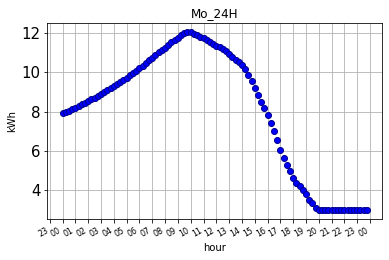

In [ ]:
fig, ax = plt.subplots()
ax.plot_date(timeOfDay[0:96], sum_parked_count, markerfacecolor='Blue', markeredgecolor='darkblue')
fig.autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(fontsize=8)
plt.yticks(fontsize=15)
plt.title('Mo_24H')
plt.ylabel('kWh')
plt.xlabel('hour')
plt.grid(True)

#plt.savefig("Mo_24H.png",dpi=72)
#files.download("Mo_24H.png")
plt.show()


# Modelierung linear regression



In [ ]:
df_sum

,zeitreihe,sum_parked_count,sum_kWh_count,sum_kWh_potential,timeOfDay,dayOfWeek,date
0,2019-04-01 00:00:00-07:00,1,23.52,67.22,00:00:00,Mo,2019-04-01
1,2019-04-01 00:15:00-07:00,1,24.77,67.22,00:15:00,Mo,2019-04-01
2,2019-04-01 00:30:00-07:00,1,26.02,67.22,00:30:00,Mo,2019-04-01
3,2019-04-01 00:45:00-07:00,1,27.27,67.22,00:45:00,Mo,2019-04-01
4,2019-04-01 01:00:00-07:00,1,28.52,67.22,01:00:00,Mo,2019-04-01
...,...,...,...,...,...,...,...
5852,2019-05-31 23:00:00-07:00,4,77.20,87.84,23:00:00,Fr,2019-05-31
5853,2019-05-31 23:15:00-07:00,4,79.28,87.84,23:15:00,Fr,2019-05-31
5854,2019-05-31 23:30:00-07:00,4,81.36,87.84,23:30:00,Fr,2019-05-31
5855,2019-05-31 23:45:00-07:00,4,83.44,87.84,23:45:00,Fr,2019-05-31


In [ ]:

# which of the predictors are quantitative, and which are qualitative?
datatypes = {'quant' : ['sum_parked_count','sum_kWh_count','sum_kWh_potential'],
             'qual': ['zeitreihe','timeOfDay','dayOfWeek','date']}

df_quant = df_sum[datatypes['quant']]

df_model = pd.concat([df_quant, df_sum[datatypes['qual']]], axis = 1)

In [ ]:
pd.DataFrame({'range': df_quant.max() - df_quant.min(),
              'mean' : df_quant.mean(),
              'std' : df_quant.std()})

,range,mean,std
sum_parked_count,32.00,7.888509,8.764023
sum_kWh_count,580.74,125.374335,137.717535
sum_kWh_potential,734.53,173.574058,181.649155


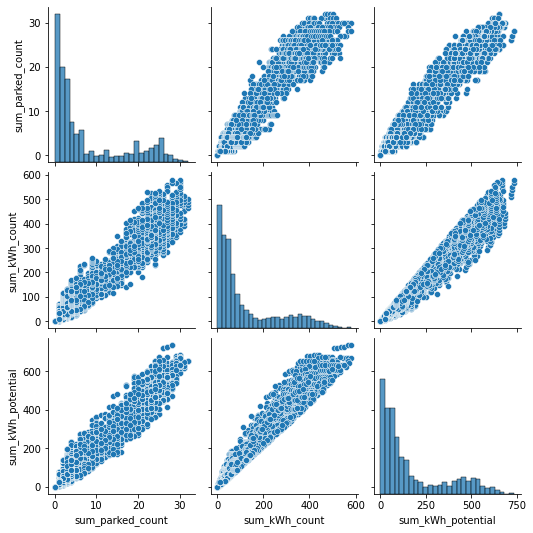

In [ ]:
sns.pairplot(df_sum)

In [ ]:
# Let's start by implementing linear regression from scratch
# using numpy linear algebra

intercept_const = pd.DataFrame({'intercept': np.ones(df_sum.shape[0])}) #dataframe mit nur 1.0 drin 

X = pd.concat([intercept_const, df_sum['sum_parked_count']], axis=1)
y = df_sum['sum_kWh_count']

def linear_model(X, y):
    """Estimation of parameteres for linear regressions model
    by Ordinary Least Squares (OLS)"""
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy     = X.T @ y
    beta    = XTX_inv @ XTy
    return beta

def predict(beta, X):
    """Perdict y given beta parameters and X variables"""
    return X @ beta

beta = linear_model(X, y)
y_pred = predict(beta, X)

In [ ]:
# The statsmodels library provides a convenient means to get the
# same statistics

X = df_sum['sum_parked_count']
X = sm.add_constant(X)     # add bias constant
y = df_sum['sum_kWh_count']

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          sum_kWh_count   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 8.132e+04
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        09:54:50   Log-Likelihood:                -29248.
No. Observations:                5857   AIC:                         5.850e+04
Df Residuals:                    5855   BIC:                         5.851e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.6497      0.628  

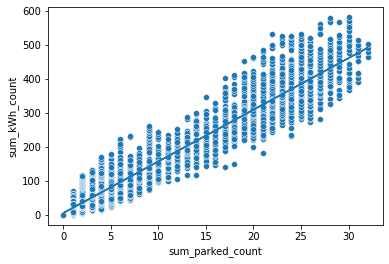

In [ ]:
# Let's plot our predicted regression

df = pd.concat([df_sum['sum_parked_count'], df_sum['sum_kWh_count']], axis=1)
ax = sns.scatterplot(x='sum_parked_count', y='sum_kWh_count', data=df)
ax.plot(df_sum['sum_parked_count'], y_pred);

Use the plot() function to produce diagnostic plots of the least squares regression fit.

In [ ]:
# Functions to emulate R's lm().plot() functionality
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions


def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try: 
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    # Residuals
    residuals = np.array(y - y_pred)
    
    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    
    # Leverage
    h_ii = H.diagonal()
    
    ## Externally studentised residual
    # In this case external studentisation is most appropriate 
    # because we are looking for outliers.
    
    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)
    
    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)
    

    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii, 
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df): 
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    # setup axis for grid
    plt.figure(1, figsize=(16, 18))
    
    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')
    
    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

Plot

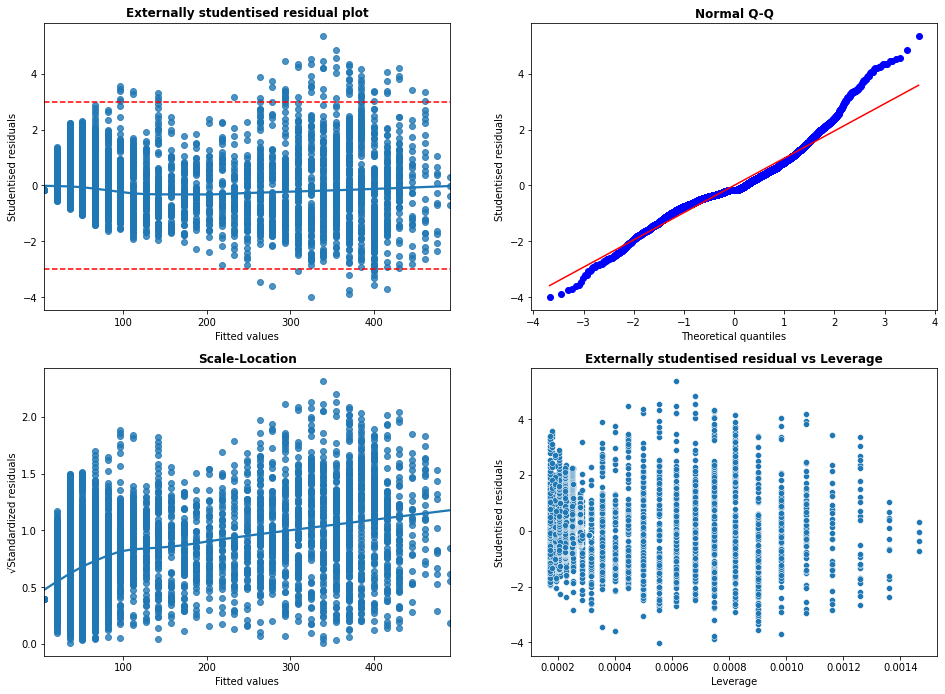

In [ ]:
X = pd.concat([df_sum['sum_parked_count']], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({'intercept': np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = df_sum['sum_kWh_count']

lm_plot(lm_stats(X, y, y_pred))

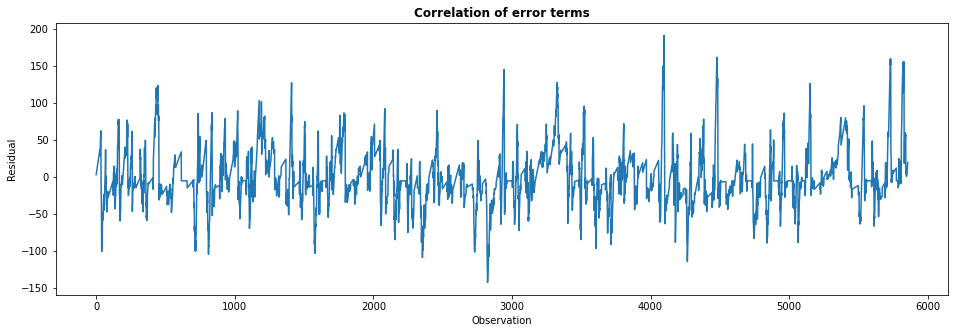

In [ ]:
def lm_residual_corr_plot(lm_stats_df):
    r = lm_stats_df['residual']
    # Residuals correlation
    plt.figure(1, figsize=(16, 5))
    ax = sns.lineplot(x=list(range(r.shape[0])), y=r)
    plt.xlabel('Observation')
    plt.ylabel('Residual')
    plt.title('Correlation of error terms', fontweight='bold');  

lm_residual_corr_plot(lm_stats(X, y, y_pred))

# Modelierung multiple regression

In [ ]:
sns.pairplot(df_sum);

correltion between variables

In [ ]:
corr_matrix = df_sum.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

In [ ]:
f = 'sum_parked_count ~ sum_kWh_count + sum_kWh_potential'
y ,X =patsy.dmatrices(f, df_sum,return_type='dataframe')

model = sm.OLS(y,X).fit()
print(model.summary())

In [ ]:
# The following predictors have P-values < 0.05 which suggests we can reject 
# the null hypothesis that they have no relationship with the response:
model.pvalues[model.pvalues < 0.05].sort_values()

diagnostic_plots multiple regression

In [ ]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

In [ ]:
diagnostic_plots(X,y)

# Modelierung OLS with time-series umgewandelt mit time.mktime

---



In [ ]:
df_sum

,zeitreihe,sum_parked_count,sum_kWh_count,sum_kWh_potential,timeOfDay,dayOfWeek,date
0,2019-04-01 00:00:00-07:00,1,23.52,67.22,00:00:00,Mo,2019-04-01
1,2019-04-01 00:15:00-07:00,1,24.77,67.22,00:15:00,Mo,2019-04-01
2,2019-04-01 00:30:00-07:00,1,26.02,67.22,00:30:00,Mo,2019-04-01
3,2019-04-01 00:45:00-07:00,1,27.27,67.22,00:45:00,Mo,2019-04-01
4,2019-04-01 01:00:00-07:00,1,28.52,67.22,01:00:00,Mo,2019-04-01
...,...,...,...,...,...,...,...
5852,2019-05-31 23:00:00-07:00,4,77.20,87.84,23:00:00,Fr,2019-05-31
5853,2019-05-31 23:15:00-07:00,4,79.28,87.84,23:15:00,Fr,2019-05-31
5854,2019-05-31 23:30:00-07:00,4,81.36,87.84,23:30:00,Fr,2019-05-31
5855,2019-05-31 23:45:00-07:00,4,83.44,87.84,23:45:00,Fr,2019-05-31


In [ ]:
print(type(df_sum['zeitreihe']))
int_zeitreihe = df_sum['zeitreihe']
print(type(int_zeitreihe[0]))
print(int_zeitreihe[0])

int_zeitreihe = int_zeitreihe.apply(lambda  var: time.mktime(var.timetuple()))
print(int_zeitreihe[0])

<class 'pandas.core.series.Series'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2019-04-01 00:00:00-07:00
1554076800.0


In [ ]:
print(int_zeitreihe[1])

1554077700.0


In [ ]:
df_model_int =  pd.DataFrame(list(zip(int_zeitreihe,df_sum['sum_parked_count'], df_sum['sum_kWh_count'], df_sum['sum_kWh_potential'])), columns = ['zeitreihe','sum_parked_count','sum_kWh_count', 'sum_kWh_potential'])

In [ ]:
print(df_model_int)

         zeitreihe  sum_parked_count  sum_kWh_count  sum_kWh_potential
0     1.554077e+09                 1          23.52              67.22
1     1.554078e+09                 1          24.77              67.22
2     1.554079e+09                 1          26.02              67.22
3     1.554080e+09                 1          27.27              67.22
4     1.554080e+09                 1          28.52              67.22
...            ...               ...            ...                ...
5852  1.559344e+09                 4          77.20              87.84
5853  1.559344e+09                 4          79.28              87.84
5854  1.559345e+09                 4          81.36              87.84
5855  1.559346e+09                 4          83.44              87.84
5856  1.559347e+09                 4          85.52              87.84

[5857 rows x 4 columns]


In [ ]:
pd.DataFrame({'range': df_model_int.max() - df_model_int.min(),
              'mean' : df_model_int.mean(),
              'std' : df_model_int.std()})

,range,mean,std
zeitreihe,5270400.00,1.556712e+09,1.521823e+06
sum_parked_count,32.00,7.888509e+00,8.764023e+00
sum_kWh_count,580.74,1.253743e+02,1.377175e+02
sum_kWh_potential,734.53,1.735741e+02,1.816492e+02


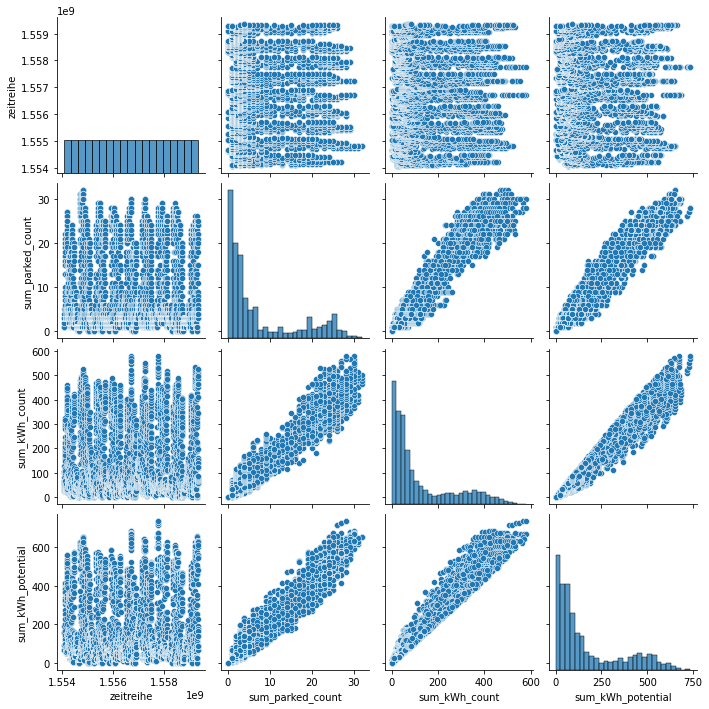

In [ ]:
sns.pairplot(df_model_int)

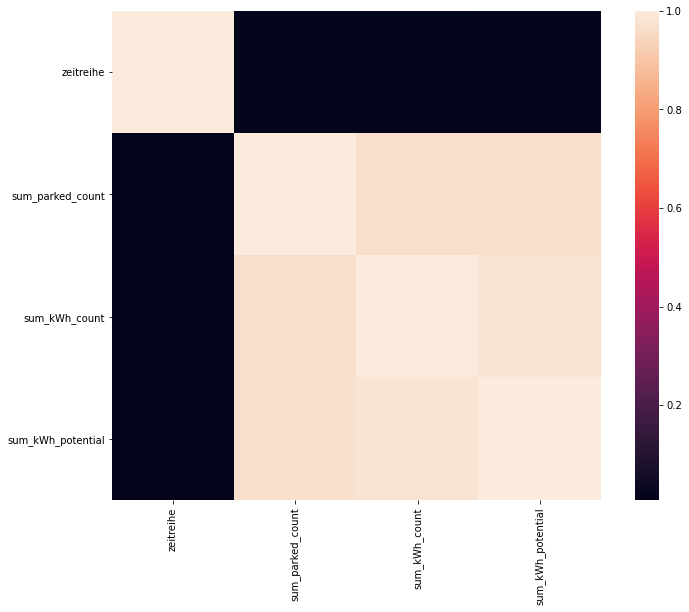

In [ ]:
corr_matrix = df_model_int.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

# Modelierung OLS with time-series andere Umwandlung
 

In [ ]:
df_sum

,zeitreihe,sum_parked_count,sum_kWh_count,sum_kWh_potential,timeOfDay,dayOfWeek,date
0,2019-04-01 00:00:00-07:00,1,23.52,67.22,00:00:00,Mo,2019-04-01
1,2019-04-01 00:15:00-07:00,1,24.77,67.22,00:15:00,Mo,2019-04-01
2,2019-04-01 00:30:00-07:00,1,26.02,67.22,00:30:00,Mo,2019-04-01
3,2019-04-01 00:45:00-07:00,1,27.27,67.22,00:45:00,Mo,2019-04-01
4,2019-04-01 01:00:00-07:00,1,28.52,67.22,01:00:00,Mo,2019-04-01
...,...,...,...,...,...,...,...
5852,2019-05-31 23:00:00-07:00,4,77.20,87.84,23:00:00,Fr,2019-05-31
5853,2019-05-31 23:15:00-07:00,4,79.28,87.84,23:15:00,Fr,2019-05-31
5854,2019-05-31 23:30:00-07:00,4,81.36,87.84,23:30:00,Fr,2019-05-31
5855,2019-05-31 23:45:00-07:00,4,83.44,87.84,23:45:00,Fr,2019-05-31


In [ ]:
df_new = 